# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

---
---

## Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

---
---

# Навигация (структура VScode)

-   Предподготовка данных
-   Проверка на дубликаты
-   Посмотрим на выбросы
-   Разбираемся с нулевыми значениями powerPS 
-   Разбираемся с нулевыми значениями price
-   Посмотрим, есть ли сильно коррелированные признаки
-   Напишем итоговый трансформер и ковейер для этих данных
-   Модели
    -   Разбиение выборок на тренировочную и тестовую
    -   Обозначим категориальные признаки
    -   DecisionTree
    -   RandomForest / LinearRegression
    -   Catboost
    -   Ищем причины получения идеального регрессора (линейная модель, и nan в RandomForest) 
    -   Продолжаем испытывать catboost модель
    -   Проверка модели на тестовой выборке
    -   Поменяем немного датасет (ограничим price)
-   Вывод
    -   1-й датасет (не урезанный таргет price)
    -   2-й датасет (урезанный таргет price)


---
---

## Описание данных

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

- name - полное название автомобиля
- seller - наименование продавца (частный, промышленный)

### Целевой признак

- Price — цена (доллары)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler     
from sklearn.preprocessing import FunctionTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

RANDOM_STATE = 42

# Предподготовка данных

In [2]:
data_base = pd.read_csv('autos.csv',
                        encoding='latin-1')
data = data_base.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dateCrawled          50000 non-null  object
 1   name                 50000 non-null  object
 2   seller               50000 non-null  object
 3   offerType            50000 non-null  object
 4   price                50000 non-null  object
 5   abtest               50000 non-null  object
 6   vehicleType          44905 non-null  object
 7   yearOfRegistration   50000 non-null  int64 
 8   gearbox              47320 non-null  object
 9   powerPS              50000 non-null  int64 
 10  model                47242 non-null  object
 11  odometer             50000 non-null  object
 12  monthOfRegistration  50000 non-null  int64 
 13  fuelType             45518 non-null  object
 14  brand                50000 non-null  object
 15  notRepairedDamage    40171 non-null  object
 16  date

## Предподготовка признаков 

#### DateCrawled, yearOfRegistration, monthOfRegistration

In [3]:
data = data[(data['yearOfRegistration'] <= 2018) & (data['yearOfRegistration'] >= 1985)]
data['yearOfRegistration'] = data['yearOfRegistration'].map(lambda x: np.where(x >= 2017, 2016, x))
data['crawl_year'] = pd.to_datetime(data['dateCrawled']).dt.year
data['age'] = data['crawl_year'] - data['yearOfRegistration']
data = data.drop(['dateCrawled', 'crawl_year', 'yearOfRegistration', 'monthOfRegistration', 'dateCreated', 'postalCode', 'lastSeen'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49160 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               49160 non-null  object
 1   seller             49160 non-null  object
 2   offerType          49160 non-null  object
 3   price              49160 non-null  object
 4   abtest             49160 non-null  object
 5   vehicleType        44195 non-null  object
 6   gearbox            46643 non-null  object
 7   powerPS            49160 non-null  int64 
 8   model              46587 non-null  object
 9   odometer           49160 non-null  object
 10  fuelType           44841 non-null  object
 11  brand              49160 non-null  object
 12  notRepairedDamage  39618 non-null  object
 13  nrOfPictures       49160 non-null  int64 
 14  age                49160 non-null  int64 
dtypes: int64(3), object(12)
memory usage: 6.0+ MB


##### вывод:

Стоимость автомобиля может зависеть от его возраста (дата взятия анкеты - дата регистрации)

#### Name

так как уникаьных значений слишком много 38 754 шт. кодирование бесполезно, тем более есть отдельные признаки модели, бренда и других описательных характеристрик, а обычно в названии зашифровано имено эти характеристики (модель, бренд, литраж и тд.) --> дропаем этот признака

In [4]:
len(data['name'].unique())

38031

In [5]:
data = data.drop('name', axis = 1)

#### Seller

In [6]:
data['seller'].unique()

array(['privat', 'gewerblich'], dtype=object)

In [7]:
data['seller'] = data['seller'].map(lambda x: np.where(x == 'privat', 1, 0))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49160 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   seller             49160 non-null  int64 
 1   offerType          49160 non-null  object
 2   price              49160 non-null  object
 3   abtest             49160 non-null  object
 4   vehicleType        44195 non-null  object
 5   gearbox            46643 non-null  object
 6   powerPS            49160 non-null  int64 
 7   model              46587 non-null  object
 8   odometer           49160 non-null  object
 9   fuelType           44841 non-null  object
 10  brand              49160 non-null  object
 11  notRepairedDamage  39618 non-null  object
 12  nrOfPictures       49160 non-null  int64 
 13  age                49160 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 5.6+ MB


##### вывод

заменили seller : 'privat' - 1, 'gewerblich' - 0

#### offerType

In [8]:
data['offerType'].unique()

array(['Angebot', 'Gesuch'], dtype=object)

In [9]:
data['offerType'] = data['offerType'].map(lambda x: np.where(x == 'Angebot', 1, 0))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49160 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   seller             49160 non-null  int64 
 1   offerType          49160 non-null  int64 
 2   price              49160 non-null  object
 3   abtest             49160 non-null  object
 4   vehicleType        44195 non-null  object
 5   gearbox            46643 non-null  object
 6   powerPS            49160 non-null  int64 
 7   model              46587 non-null  object
 8   odometer           49160 non-null  object
 9   fuelType           44841 non-null  object
 10  brand              49160 non-null  object
 11  notRepairedDamage  39618 non-null  object
 12  nrOfPictures       49160 non-null  int64 
 13  age                49160 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 5.6+ MB


##### вывод

заменили offerType : 'Angebot' - 1, 'Gesuch' - 0

#### Price

In [10]:
data['price']

0         $5,000
1         $8,500
2         $8,990
3         $4,350
4         $1,350
          ...   
49995    $24,900
49996     $1,980
49997    $13,200
49998    $22,900
49999     $1,250
Name: price, Length: 49160, dtype: object

In [11]:
def price_change(x):
    x = x.replace('$', '').replace(',', '')
    return int(x)

data['price'] = data['price'].map(price_change)
data['price'].head()

0    5000
1    8500
2    8990
3    4350
4    1350
Name: price, dtype: int64

In [12]:
data = data.drop('abtest', axis = 1)

#### vehicleType

In [13]:
data['vehicleType'].unique()

array(['bus', 'limousine', 'kleinwagen', 'kombi', nan, 'coupe', 'suv',
       'cabrio', 'andere'], dtype=object)

In [14]:
data['vehicleType'] = data['vehicleType'].fillna('other')
data['vehicleType'].unique()

array(['bus', 'limousine', 'kleinwagen', 'kombi', 'other', 'coupe', 'suv',
       'cabrio', 'andere'], dtype=object)

##### вывод: 

Вконечном трасформаторе преобразуем в OneHot() матрицу

#### GearBox

In [15]:
data['gearbox'].unique()

array(['manuell', 'automatik', nan], dtype=object)

In [16]:
data_base[data_base['gearbox'].isnull()].head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,odometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
11,2016-03-16 18:45:34,Mercedes_A140_Motorschaden,privat,Angebot,$350,control,NaN,2000,NaN,0,NaN,"150,000km",0,benzin,mercedes_benz,NaN,2016-03-16 00:00:00,0,17498,2016-03-16 18:45:34
27,2016-03-27 18:45:01,Hat_einer_Ahnung_mit_Ford_Galaxy_HILFE,privat,Angebot,$0,control,NaN,2005,NaN,0,NaN,"150,000km",0,NaN,ford,NaN,2016-03-27 00:00:00,0,66701,2016-03-27 18:45:01
52,2016-03-25 18:50:03,Senator_A_3.0E_Karosserie_restauriert_m._viele...,privat,Angebot,"$3,500",test,limousine,1985,NaN,0,andere,"5,000km",0,benzin,opel,nein,2016-03-25 00:00:00,0,63500,2016-04-07 00:46:00
60,2016-03-23 21:55:29,VW_Vento_1_8_Tuev_NEU,privat,Angebot,"$1,199",test,limousine,1996,NaN,90,NaN,"150,000km",0,benzin,volkswagen,nein,2016-03-23 00:00:00,0,1665,2016-04-06 05:45:36
64,2016-04-05 07:36:19,Autotransport__Abschlepp_Schlepper,privat,Angebot,$40,test,NaN,2011,NaN,0,5er,"150,000km",5,NaN,bmw,NaN,2016-04-05 00:00:00,0,40591,2016-04-07 12:16:01


In [17]:
data['gearbox'] = data['gearbox'].fillna('не указана')    

#### model

In [18]:
data['model'].unique()

array(['andere', '7er', 'golf', 'fortwo', 'focus', 'voyager', 'arosa',
       'megane', nan, 'a3', 'clio', 'vectra', 'scirocco', '3er', 'a4',
       '911', 'cooper', '5er', 'polo', 'e_klasse', '2_reihe', 'c_klasse',
       'corsa', 'mondeo', 'altea', 'a1', 'twingo', 'a_klasse', 'cl',
       '3_reihe', 's_klasse', 'sandero', 'passat', 'primera', 'fiesta',
       'wrangler', 'clubman', 'a6', 'transporter', 'astra', 'v40',
       'ibiza', 'micra', '1er', 'yaris', 'colt', '6_reihe', '5_reihe',
       'corolla', 'ka', 'tigra', 'punto', 'vito', 'cordoba', 'galaxy',
       '100', 'sharan', 'octavia', 'm_klasse', 'lupo', 'superb', 'meriva',
       'c_max', 'laguna', 'touran', '1_reihe', 'm_reihe', 'touareg',
       'seicento', 'avensis', 'vivaro', 'x_reihe', 'ducato', 'carnival',
       'boxster', 'signum', 'zafira', 'rav', 'a5', 'beetle', 'c_reihe',
       'phaeton', 'i_reihe', 'sl', 'insignia', 'up', 'civic', '80',
       'mx_reihe', 'omega', 'sorento', 'z_reihe', 'berlingo', 'clk',
       '

In [19]:
data['model'] = data['model'].fillna('other')

In [20]:
data_prp = data.copy()
mask = data_prp.groupby(['brand', 'model', 'age'])['price'].mean()
mask.index

MultiIndex([('alfa_romeo',      '145',  0),
            ('alfa_romeo',      '145', 16),
            ('alfa_romeo',      '145', 21),
            ('alfa_romeo',      '147',  0),
            ('alfa_romeo',      '147',  6),
            ('alfa_romeo',      '147',  7),
            ('alfa_romeo',      '147',  9),
            ('alfa_romeo',      '147', 10),
            ('alfa_romeo',      '147', 11),
            ('alfa_romeo',      '147', 12),
            ...
            (     'volvo', 'xc_reihe',  4),
            (     'volvo', 'xc_reihe',  5),
            (     'volvo', 'xc_reihe',  6),
            (     'volvo', 'xc_reihe',  7),
            (     'volvo', 'xc_reihe',  8),
            (     'volvo', 'xc_reihe',  9),
            (     'volvo', 'xc_reihe', 10),
            (     'volvo', 'xc_reihe', 11),
            (     'volvo', 'xc_reihe', 12),
            (     'volvo', 'xc_reihe', 13)],
           names=['brand', 'model', 'age'], length=4508)

In [21]:
data_prp = data_prp.set_index(['brand', 'model', 'age']).loc[mask.index]
data_prp['model_coder'] = mask
data_prp.head()

seller  offerType  price vehicleType     gearbox  \
brand      model age                                                     
alfa_romeo 145   0         1          1    399       other  не указана   
                 16        1          1   5000   limousine     manuell   
                 16        1          1    500       other  не указана   
                 21        1          1    500      andere     manuell   
           147   0         1          1    850       other     manuell   

                      powerPS   odometer fuelType notRepairedDamage  \
brand      model age                                                  
alfa_romeo 145   0        103  150,000km   benzin               NaN   
                 16       120  150,000km   benzin              nein   
                 16         0  150,000km      NaN               NaN   
                 21       100  100,000km   benzin              nein   
           147   0          0  150,000km   diesel               NaN   

                      nrOfPictures  model_coder  
brand      model age                             
alfa_romeo 145   0               0      399.000  
                 16              0     2750.000  
                 16              0     2750.000  
                 21              0      500.000  
           147   0               0     2131.125

In [22]:
data = data_prp.reset_index()
data.head()

,brand,model,age,seller,offerType,price,vehicleType,gearbox,powerPS,odometer,fuelType,notRepairedDamage,nrOfPictures,model_coder
0,alfa_romeo,145,0,1,1,399,other,не указана,103,"150,000km",benzin,NaN,0,399.000
1,alfa_romeo,145,16,1,1,5000,limousine,manuell,120,"150,000km",benzin,nein,0,2750.000
2,alfa_romeo,145,16,1,1,500,other,не указана,0,"150,000km",NaN,NaN,0,2750.000
3,alfa_romeo,145,21,1,1,500,andere,manuell,100,"100,000km",benzin,nein,0,500.000
4,alfa_romeo,147,0,1,1,850,other,manuell,0,"150,000km",diesel,NaN,0,2131.125


#### odometer

In [23]:
def odometer_changer(x):
    x = x.replace(',', '').replace('km', '')
    return int(x)

data['odometer'] = data['odometer'].map(odometer_changer)
data['odometer'].unique()

array([150000, 100000,  70000, 125000,  50000,  60000,  80000,  90000,
         5000,  20000,  10000,  40000,  30000], dtype=int64)

#### fuelType

In [24]:
data['fuelType'].unique()

array(['benzin', nan, 'diesel', 'lpg', 'hybrid', 'cng', 'elektro',
       'andere'], dtype=object)

In [25]:
len(data[data['fuelType'].isnull()])

4319

In [26]:
data['fuelType'] = data['fuelType'].fillna('не указан')

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49160 entries, 0 to 49159
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              49160 non-null  object 
 1   model              49160 non-null  object 
 2   age                49160 non-null  int64  
 3   seller             49160 non-null  int64  
 4   offerType          49160 non-null  int64  
 5   price              49160 non-null  int64  
 6   vehicleType        49160 non-null  object 
 7   gearbox            49160 non-null  object 
 8   powerPS            49160 non-null  int64  
 9   odometer           49160 non-null  int64  
 10  fuelType           49160 non-null  object 
 11  notRepairedDamage  39618 non-null  object 
 12  nrOfPictures       49160 non-null  int64  
 13  model_coder        49160 non-null  float64
dtypes: float64(1), int64(7), object(6)
memory usage: 5.3+ MB


In [28]:
data['notRepairedDamage'].unique()

array([nan, 'nein', 'ja'], dtype=object)

In [29]:
len(data[data['notRepairedDamage'].isnull()])

9542

In [30]:
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('не указано')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49160 entries, 0 to 49159
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              49160 non-null  object 
 1   model              49160 non-null  object 
 2   age                49160 non-null  int64  
 3   seller             49160 non-null  int64  
 4   offerType          49160 non-null  int64  
 5   price              49160 non-null  int64  
 6   vehicleType        49160 non-null  object 
 7   gearbox            49160 non-null  object 
 8   powerPS            49160 non-null  int64  
 9   odometer           49160 non-null  int64  
 10  fuelType           49160 non-null  object 
 11  notRepairedDamage  49160 non-null  object 
 12  nrOfPictures       49160 non-null  int64  
 13  model_coder        49160 non-null  float64
dtypes: float64(1), int64(7), object(6)
memory usage: 5.3+ MB


#### nrOfPictures

по какой-то причине 0 фотографий у всех анкет , дроп признака 

In [31]:
data['nrOfPictures'].unique()

array([0], dtype=int64)

In [32]:
data = data.drop('nrOfPictures', axis = 1)

#### Lastseen

все пользователи заходили в этом году, скорее всего анкета актуальная значи дроп (не влияет на стоимость авто)

#### brand

In [33]:
values_brand_mask = \
data.groupby(['model', 'brand'])['price'].mean()

values_brand_mask

model    brand     
100      audi           1671.821429
145      alfa_romeo     1599.750000
147      alfa_romeo     2322.870588
156      alfa_romeo     1426.619565
159      alfa_romeo     6398.529412
                           ...     
yaris    toyota         4323.418605
yeti     skoda         15351.400000
ypsilon  lancia         1247.680000
z_reihe  bmw           16293.008264
zafira   opel           3486.879433
Name: price, Length: 331, dtype: float64

In [34]:
data_probnik = data.copy()
data_probnik = data_probnik.set_index(['model', 'brand']).loc[values_brand_mask.index]
data_probnik['brand_coder'] = values_brand_mask

In [35]:
data = data_probnik.reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49160 entries, 0 to 49159
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              49160 non-null  object 
 1   brand              49160 non-null  object 
 2   age                49160 non-null  int64  
 3   seller             49160 non-null  int64  
 4   offerType          49160 non-null  int64  
 5   price              49160 non-null  int64  
 6   vehicleType        49160 non-null  object 
 7   gearbox            49160 non-null  object 
 8   powerPS            49160 non-null  int64  
 9   odometer           49160 non-null  int64  
 10  fuelType           49160 non-null  object 
 11  notRepairedDamage  49160 non-null  object 
 12  model_coder        49160 non-null  float64
 13  brand_coder        49160 non-null  float64
dtypes: float64(2), int64(6), object(6)
memory usage: 5.3+ MB


## Проверка на дубликаты

In [36]:
data.duplicated().sum()

1328

In [37]:
data = data.drop_duplicates()

## Посмотрим на выбросы

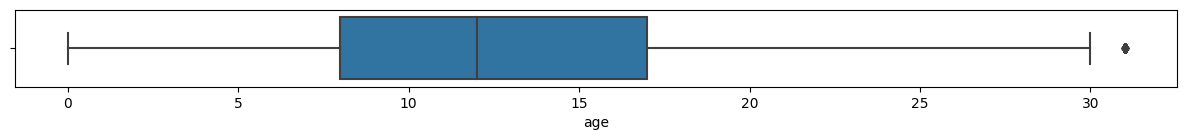

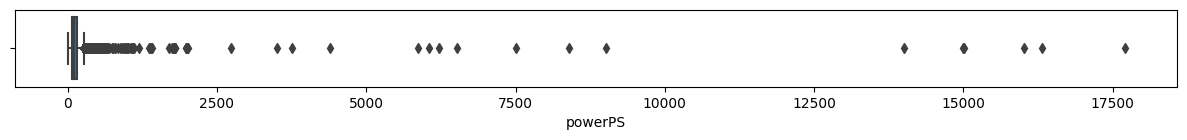

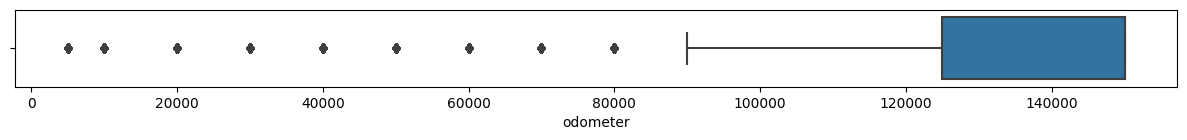

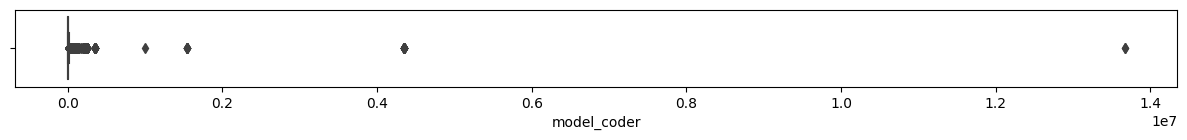

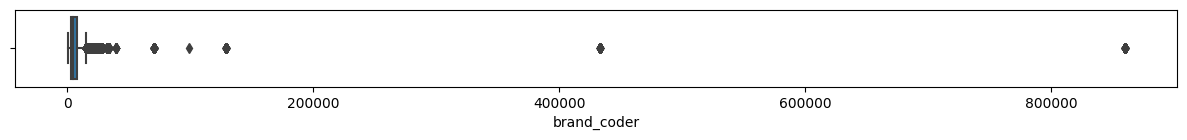

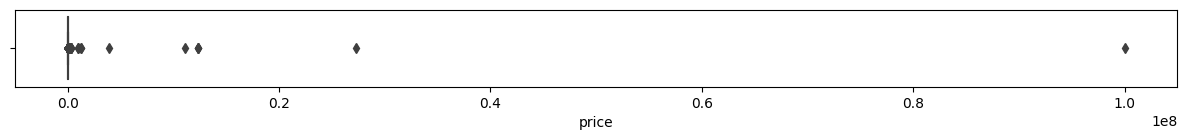

In [38]:
num_features_target = ['age','powerPS', 'odometer', 'model_coder', 'brand_coder', 'price']

for feature in num_features_target:
    plt.figure(figsize = (15,1))
    sns.boxplot(data = data,
                x = feature)
    plt.show()

In [39]:
data.describe().round()

,age,seller,offerType,price,powerPS,odometer,model_coder,brand_coder
count,47832.0,47832.0,47832.0,47832.0,47832.0,47832.0,47832.0,47832.0
mean,12.0,1.0,1.0,9526.0,117.0,126152.0,9498.0,9447.0
std,6.0,0.0,0.0,487096.0,213.0,39592.0,132587.0,45695.0
min,0.0,0.0,0.0,0.0,0.0,5000.0,0.0,250.0
25%,8.0,1.0,1.0,1100.0,72.0,125000.0,1481.0,2871.0
50%,12.0,1.0,1.0,2900.0,107.0,150000.0,3072.0,4851.0
75%,17.0,1.0,1.0,7192.0,150.0,150000.0,7129.0,7731.0
max,31.0,1.0,1.0,99999999.0,17700.0,150000.0,13666986.0,859765.0


In [40]:
data = data[(data['powerPS'] <= 350) &
            (data['odometer'] >= 90000) &
            (data['model_coder'] <= 0.1*10**7) &
            (data['price'] <= 0.1*10**8) &
            (data['brand_coder'] <= 20000)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37225 entries, 0 to 49159
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              37225 non-null  object 
 1   brand              37225 non-null  object 
 2   age                37225 non-null  int64  
 3   seller             37225 non-null  int64  
 4   offerType          37225 non-null  int64  
 5   price              37225 non-null  int64  
 6   vehicleType        37225 non-null  object 
 7   gearbox            37225 non-null  object 
 8   powerPS            37225 non-null  int64  
 9   odometer           37225 non-null  int64  
 10  fuelType           37225 non-null  object 
 11  notRepairedDamage  37225 non-null  object 
 12  model_coder        37225 non-null  float64
 13  brand_coder        37225 non-null  float64
dtypes: float64(2), int64(6), object(6)
memory usage: 4.3+ MB


#### Разбираемся с нулевыми значениями powerPS (заполнение по среднему (бренд, модель))

In [41]:
data_3 = data.copy()

power_Ps_0_index = data[data['powerPS'] == 0].index

values_power_PS =\
data.groupby(['brand', 'model'])['powerPS'].mean()

values_power_PS.reset_index()

,brand,model,powerPS
0,alfa_romeo,145,80.750000
1,alfa_romeo,147,113.333333
2,alfa_romeo,156,145.022727
3,alfa_romeo,159,161.233333
4,alfa_romeo,andere,140.888889
...,...,...,...
290,volvo,other,122.750000
291,volvo,s60,179.200000
292,volvo,v50,129.551724
293,volvo,v70,151.431579


In [42]:
data_problem = data_3[data_3['powerPS'] == 0]
columns_do = data_problem.columns


data_problem = data_problem.drop('powerPS', axis = 1)

data_problem = \
data_problem.merge(values_power_PS.reset_index(),
                   on = ['brand', 'model'],
                   )
data_problem = data_problem[columns_do]
data_problem.head()

,model,brand,age,seller,offerType,price,vehicleType,gearbox,powerPS,odometer,fuelType,notRepairedDamage,model_coder,brand_coder
0,100,audi,22,1,1,450,kombi,manuell,132.709091,150000,benzin,ja,699.750,1671.821429
1,100,audi,30,1,1,499,limousine,manuell,132.709091,150000,benzin,nein,399.500,1671.821429
2,100,audi,31,1,1,150,other,не указана,132.709091,150000,benzin,не указано,950.000,1671.821429
3,145,alfa_romeo,16,1,1,500,other,не указана,80.750000,150000,не указан,не указано,2750.000,1599.750000
4,147,alfa_romeo,0,1,1,850,other,manuell,113.333333,150000,diesel,не указано,2131.125,2322.870588


In [43]:
data_3 =\
pd.concat([data_3[data_3['powerPS'] != 0],
           data_problem],
           ignore_index = True)
data = data_3[data_3['powerPS'] != 0]

In [44]:
data[data['powerPS'] == 0]

,model,brand,age,seller,offerType,price,vehicleType,gearbox,powerPS,odometer,fuelType,notRepairedDamage,model_coder,brand_coder


#### Разбираемся с нулевыми значениями price (заполнение по среднему (бренд, модель, powerPS, odometer, age))

In [45]:
data_price_problem = data[data['price'] == 0]
data_price_problem.head()

,model,brand,age,seller,offerType,price,vehicleType,gearbox,powerPS,odometer,fuelType,notRepairedDamage,model_coder,brand_coder
18,100,audi,24,1,1,0,limousine,manuell,150.0,150000,benzin,ja,1804.800000,1671.821429
35,100,audi,25,1,1,0,limousine,manuell,116.0,150000,не указан,ja,1309.900000,1671.821429
174,156,alfa_romeo,15,1,1,0,kombi,manuell,144.0,150000,benzin,ja,881.866667,1426.619565
178,156,alfa_romeo,15,1,1,0,kombi,manuell,140.0,150000,diesel,ja,881.866667,1426.619565
205,156,alfa_romeo,18,1,1,0,limousine,manuell,150.0,150000,benzin,ja,658.666667,1426.619565


In [46]:
values_price_problem =\
data.groupby(['brand', 'model', 'powerPS','age'])['price'].mean()
values_price_problem.reset_index()

,brand,model,powerPS,age,price
0,alfa_romeo,145,80.75,16,500.0
1,alfa_romeo,145,100.00,21,500.0
2,alfa_romeo,145,103.00,0,399.0
3,alfa_romeo,145,120.00,16,5000.0
4,alfa_romeo,147,76.00,19,500.0
...,...,...,...,...,...
13317,volvo,xc_reihe,210.00,13,6750.0
13318,volvo,xc_reihe,215.00,4,28990.0
13319,volvo,xc_reihe,215.00,5,21245.0
13320,volvo,xc_reihe,239.00,9,9900.0


In [47]:
column_do = data_price_problem.columns
data_price_problem = data_price_problem.set_index(['brand', 'model', 'powerPS','age']).drop('price', axis = 1)

data_to_concat = \
data_price_problem.merge(values_price_problem.reset_index(),
                         on = ['brand', 'model', 'powerPS','age'])

data_to_concat = data_to_concat[column_do]
data_to_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 0 to 975
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              976 non-null    object 
 1   brand              976 non-null    object 
 2   age                976 non-null    int64  
 3   seller             976 non-null    int64  
 4   offerType          976 non-null    int64  
 5   price              976 non-null    float64
 6   vehicleType        976 non-null    object 
 7   gearbox            976 non-null    object 
 8   powerPS            976 non-null    float64
 9   odometer           976 non-null    int64  
 10  fuelType           976 non-null    object 
 11  notRepairedDamage  976 non-null    object 
 12  model_coder        976 non-null    float64
 13  brand_coder        976 non-null    float64
dtypes: float64(4), int64(4), object(6)
memory usage: 114.4+ KB


In [48]:
data =\
pd.concat([data[data['price'] != 0],
           data_to_concat[data_to_concat['price'] != 0]],
           ignore_index = True)
data

,model,brand,age,seller,offerType,price,vehicleType,gearbox,powerPS,odometer,fuelType,notRepairedDamage,model_coder,brand_coder
0,100,audi,0,1,1,1250.000000,other,manuell,136.000000,150000,benzin,не указано,1250.000000,1671.821429
1,100,audi,9,1,1,7190.000000,cabrio,automatik,163.000000,150000,diesel,nein,7190.000000,1671.821429
2,100,audi,21,1,1,990.000000,other,manuell,174.000000,150000,не указан,не указано,990.000000,1671.821429
3,100,audi,22,1,1,650.000000,kombi,manuell,116.000000,150000,benzin,nein,699.750000,1671.821429
4,100,audi,22,1,1,1199.000000,limousine,manuell,150.000000,150000,benzin,nein,699.750000,1671.821429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36947,v50,volvo,12,1,1,2099.500000,kombi,manuell,129.551724,150000,diesel,не указано,3532.111111,5139.774194
36948,v70,volvo,17,1,1,275.000000,kombi,manuell,151.431579,150000,не указан,nein,1765.384615,3809.525773
36949,vito,mercedes_benz,9,1,1,4633.333333,other,не указана,101.413793,150000,не указан,не указано,6631.800000,7295.238095
36950,vito,mercedes_benz,16,1,1,999.500000,bus,manuell,101.413793,150000,diesel,не указано,2108.000000,7295.238095


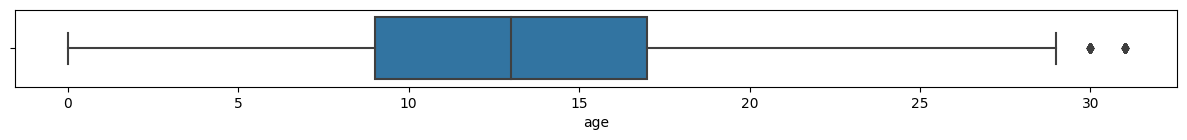

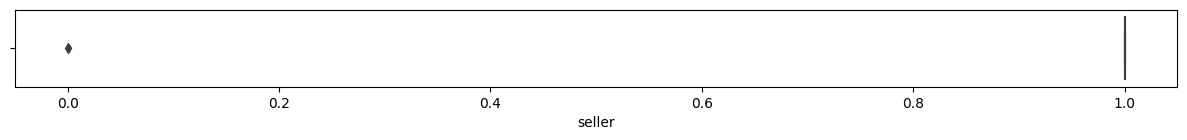

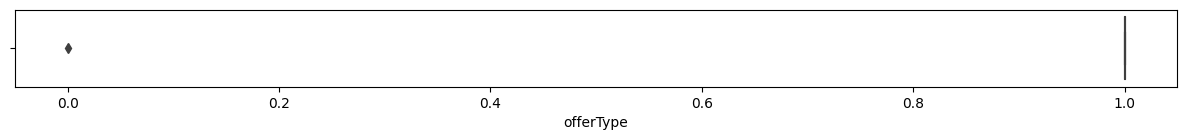

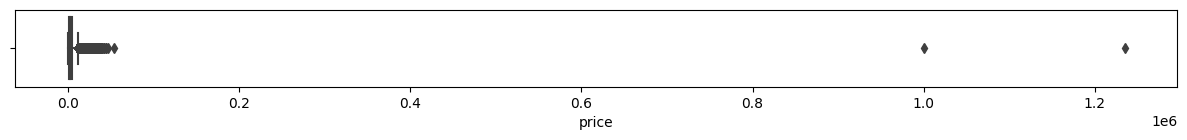

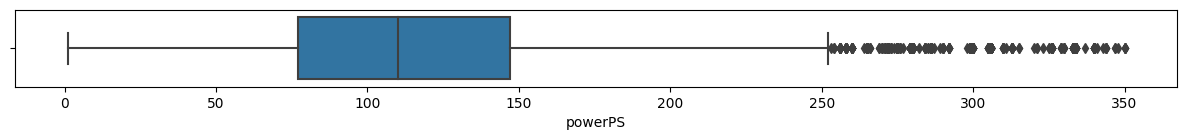

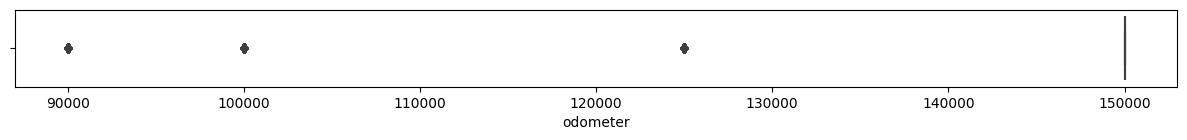

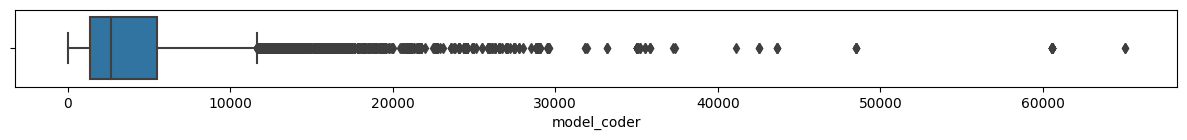

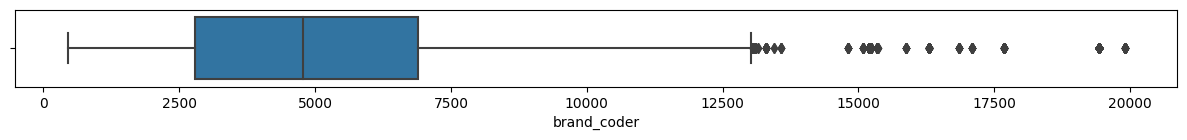

In [49]:
num_features_target = data.describe().columns.to_list()

for feature in num_features_target:
    plt.figure(figsize = (15,1))
    sns.boxplot(data = data,
                x = feature)
    plt.show()

## Посмотрим, есть ли сильно коррелированные признаки

таких нет

In [50]:
data.corr()

C:\Users\oudel\AppData\Local\Temp\ipykernel_6756\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,age,seller,offerType,price,powerPS,odometer,model_coder,brand_coder
age,1.000000,-0.002561,0.001762,-0.207332,-0.143638,0.189342,-0.461639,-0.126601
seller,-0.002561,1.000000,-0.000027,0.002238,0.002819,-0.002503,0.003866,0.003509
offerType,0.001762,-0.000027,1.000000,-0.000030,0.001615,-0.002503,-0.006012,-0.008182
price,-0.207332,0.002238,-0.000030,1.000000,0.282157,-0.127401,0.458445,0.261370
powerPS,-0.143638,0.002819,0.001615,0.282157,1.000000,0.049716,0.484699,0.571439
odometer,0.189342,-0.002503,-0.002503,-0.127401,0.049716,1.000000,-0.194239,-0.000507
model_coder,-0.461639,0.003866,-0.006012,0.458445,0.484699,-0.194239,1.000000,0.561483
brand_coder,-0.126601,0.003509,-0.008182,0.261370,0.571439,-0.000507,0.561483,1.000000


# Напишем итоговый трансформер и ковеер для этих данных

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import KNNImputer

##### Создание признака возраст автомобиля (год скрапинга анкеты - год регистрации авто)
class AgeOfAuto(TransformerMixin):
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X = X[(X['yearOfRegistration'] <= 2018) & (X['yearOfRegistration'] >= 1985)]
        X['yearOfRegistration'] = X['yearOfRegistration'].map(lambda x: np.where(x >= 2017, 2016, x))
        X['crawl_year'] = pd.to_datetime(X['dateCrawled']).dt.year
        X['age'] = X['crawl_year'] - X['yearOfRegistration']
        X = X.drop(['yearOfRegistration',
                    'crawl_year',
                    'dateCrawled',
                    'name',
                    'monthOfRegistration',
                    'dateCreated',
                    'nrOfPictures',
                    'postalCode',
                    'lastSeen',
                    'abtest',
                    'offerType'], axis = 1)
        return X

##### Убираем значок доллара и запятую в признаке price
class DollarDeletePrice(TransformerMixin):
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X['price'] = X['price'].map(price_change)
        return X


#### Заполнение vehicleType 'other'
def fillna_other_vehicleType(X):
    X['vehicleType'] = X['vehicleType'].fillna('other')
    return X

#### Заполненение gearbox 'не указана'
def fillna_gearbox(X):
    X['gearbox'] = X['gearbox'].fillna('не указана')
    return X

#### Заполнение model 'other'
def fillna_model(X):
    X['model'] = X['model'].fillna('other')
    return X

#### убираем запятую и 'km' в odometer
def mapping_odometer(X):
    X['odometer'] = X['odometer'].map(odometer_changer)
    return X
        
#### заполняем fuelType
def fillna_fuelType(X):
    X['fuelType'] = X['fuelType'].fillna('не указан')
    return X

#### Запролняем notRepairedDamage 
def fillna_notRepairedDamage(X):
    X['notRepairedDamage'] = X['notRepairedDamage'].fillna('не указано')
    return X

def zamena_0_nan_NaN_powerPS(X):    # это нужно для заполнения потом этих значений Imputer
    X.loc[(X['powerPS'] == 0), 'powerPS'] = np.nan
    return X

### Удаление 0 price
def zero_price_delete(X):
    X = X[X['price'] != 0]
    return X

### Удаление дублей
def dubli_drop(X):
    X = X.drop_duplicates()
    return X


### Выбросы
def vibrosi(X):
    num_features_target = X.describe().columns.to_list()
    for num_column in num_features_target:
                    quantile_upper = np.quantile(X[num_column], q = 0.75)
                    quantile_down = np.quantile(X[num_column], q = 0.25)
                    IQR = quantile_upper - quantile_down
                    max = quantile_upper + 1.5*IQR
                    min = quantile_down - 1.5*IQR
                    X = X[(X[num_column] <= max) & (X[num_column] >= min)]
    return X


mapper = DataFrameMapper([
    (['age'], None),
    (['price'], DollarDeletePrice()),        # Еще удалить 0
    (['vehicleType'], FunctionTransformer(fillna_other_vehicleType)),
    (['gearbox'], FunctionTransformer(fillna_gearbox)),
    (['model'], FunctionTransformer(fillna_model)),
    (['odometer'], FunctionTransformer(mapping_odometer)),
    (['fuelType'], FunctionTransformer(fillna_fuelType)),
    (['notRepairedDamage'], FunctionTransformer(fillna_notRepairedDamage)),
    (['seller'], None),
    (['brand'], None),
    (['powerPS'], [FunctionTransformer(zamena_0_nan_NaN_powerPS), KNNImputer()])
], input_df = True, df_out = True)


full_pipeline = Pipeline([
    ('preprocess_age', AgeOfAuto()),    # создаем признак age (возраст авто)
    ('mapper', mapper),
    ('zero_price_delete', FunctionTransformer(zero_price_delete)),
    ('dublicat_drop', FunctionTransformer(dubli_drop)),
    ('vibrosi', FunctionTransformer(vibrosi))
])

In [52]:
data = data_base.copy()

In [53]:
df_prepare = full_pipeline.fit_transform(data)

C:\Users\oudel\AppData\Local\Temp\ipykernel_6756\1393505137.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['yearOfRegistration'] = X['yearOfRegistration'].map(lambda x: np.where(x >= 2017, 2016, x))
C:\Users\oudel\AppData\Local\Temp\ipykernel_6756\1393505137.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['crawl_year'] = pd.to_datetime(X['dateCrawled']).dt.year
C:\Users\oudel\AppData\Local\Temp\ipykernel_6756\1393505137.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [54]:
df_prepare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36033 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                36033 non-null  int64  
 1   price              36033 non-null  int64  
 2   vehicleType        36033 non-null  object 
 3   gearbox            36033 non-null  object 
 4   model              36033 non-null  object 
 5   odometer           36033 non-null  int64  
 6   fuelType           36033 non-null  object 
 7   notRepairedDamage  36033 non-null  object 
 8   seller             36033 non-null  object 
 9   brand              36033 non-null  object 
 10  powerPS            36033 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 3.3+ MB


# Модели 

На всех моделях удобно будет искать RMSE

## Разбиение выборок на тренировочную и тестовую

In [55]:
def split(data):
    y = data['price']
    X = data.drop('price', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.2,
                                                        random_state = RANDOM_STATE)
    return X_train, X_test, y_train, y_test


X_train_1, X_test_1, y_train_1, y_test_1 = split(data = df_prepare)


#### Обозначим категориальные признаки
cat_features = list(df_prepare.select_dtypes('object').columns)

### DecisionTree

In [56]:
'''model_tree = DecisionTreeRegressor(random_state = RANDOM_STATE)

def fit_predict_error(model,
                      X_train,
                      X_test,
                      y_train,
                      y_test):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_true = y_test,
                                      y_pred = y_pred))
    print(f'Модель: {model}')
    print(f'RMSE: {RMSE}')


fit_predict_error(model_tree,
                  X_train_1,
                  X_test_1,
                  y_train_1,
                  y_test_1)'''

"model_tree = DecisionTreeRegressor(random_state = RANDOM_STATE)\n\ndef fit_predict_error(model,\n                      X_train,\n                      X_test,\n                      y_train,\n                      y_test):\n    \n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_test)\n    RMSE = np.sqrt(mean_squared_error(y_true = y_test,\n                                      y_pred = y_pred))\n    print(f'Модель: {model}')\n    print(f'RMSE: {RMSE}')\n\n\nfit_predict_error(model_tree,\n                  X_train_1,\n                  X_test_1,\n                  y_train_1,\n                  y_test_1)"

## RandomForest / LinearRegression

In [57]:
'''model_forest = RandomForestRegressor(random_state = RANDOM_STATE,
                                     n_jobs = -1)
lin_model = LinearRegression()


fit_predict_error(model_forest,
                  X_train_1,
                  X_test_1,
                  y_train_1,
                  y_test_1)
print('\n')
fit_predict_error(lin_model,
                  X_train_1,
                  X_test_1,
                  y_train_1,
                  y_test_1)'''

"model_forest = RandomForestRegressor(random_state = RANDOM_STATE,\n                                     n_jobs = -1)\nlin_model = LinearRegression()\n\n\nfit_predict_error(model_forest,\n                  X_train_1,\n                  X_test_1,\n                  y_train_1,\n                  y_test_1)\nprint('\n')\nfit_predict_error(lin_model,\n                  X_train_1,\n                  X_test_1,\n                  y_train_1,\n                  y_test_1)"

## Catboost

In [58]:
'''cat_model = CatBoostRegressor(iterations = 100,
                              learning_rate = 0.01,
                              random_state = RANDOM_STATE,
                              custom_metric = 'RMSE')

cat_model.fit(X_train_1,
              y_train_1,
              cat_features = cat_features,
              eval_set = (X_test_1, y_test_1),
              plot = True,
              verbose = 0)'''

"cat_model = CatBoostRegressor(iterations = 100,\n                              learning_rate = 0.01,\n                              random_state = RANDOM_STATE,\n                              custom_metric = 'RMSE')\n\ncat_model.fit(X_train_1,\n              y_train_1,\n              cat_features = cat_features,\n              eval_set = (X_test_1, y_test_1),\n              plot = True,\n              verbose = 0)"

In [59]:
'''cat_model = CatBoostRegressor(iterations = 1000,
                              learning_rate = 0.05,
                              random_state = RANDOM_STATE,
                              custom_metric = 'RMSE')

cat_model.fit(X_train_1,
              y_train_1,
              cat_features = cat_features,
              eval_set = (X_test_1, y_test_1),
              plot = True,
              verbose = 0)'''

"cat_model = CatBoostRegressor(iterations = 1000,\n                              learning_rate = 0.05,\n                              random_state = RANDOM_STATE,\n                              custom_metric = 'RMSE')\n\ncat_model.fit(X_train_1,\n              y_train_1,\n              cat_features = cat_features,\n              eval_set = (X_test_1, y_test_1),\n              plot = True,\n              verbose = 0)"

In [60]:
'''cat_model = CatBoostRegressor(iterations = 2000,
                              learning_rate = 0.07,
                              random_state = RANDOM_STATE,
                              custom_metric = 'RMSE')

cat_model.fit(X_train_1,
              y_train_1,
              cat_features = cat_features,
              eval_set = (X_test_1, y_test_1),
              plot = True,
              verbose = 0)'''

"cat_model = CatBoostRegressor(iterations = 2000,\n                              learning_rate = 0.07,\n                              random_state = RANDOM_STATE,\n                              custom_metric = 'RMSE')\n\ncat_model.fit(X_train_1,\n              y_train_1,\n              cat_features = cat_features,\n              eval_set = (X_test_1, y_test_1),\n              plot = True,\n              verbose = 0)"

In [61]:
'''grid_random = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),
                           param_grid = {'n_estimators': np.arange(100,1000,100)},
                           scoring = mean_squared_error,
                           cv = ShuffleSplit(n_splits = 5,
                                             test_size = 0.2,
                                             random_state = RANDOM_STATE),
                           n_jobs = 10)

grid_random.fit(X_train_1, y_train_1)
best_forest = grid_random.best_estimator_
print(grid_random.best_params_)
print(grid_random.best_score_)'''

"grid_random = GridSearchCV(estimator = RandomForestRegressor(random_state = RANDOM_STATE),\n                           param_grid = {'n_estimators': np.arange(100,1000,100)},\n                           scoring = mean_squared_error,\n                           cv = ShuffleSplit(n_splits = 5,\n                                             test_size = 0.2,\n                                             random_state = RANDOM_STATE),\n                           n_jobs = 10)\n\ngrid_random.fit(X_train_1, y_train_1)\nbest_forest = grid_random.best_estimator_\nprint(grid_random.best_params_)\nprint(grid_random.best_score_)"

## Ищем причины получения идеального регрессора (линейная модель, и nan в RandomForest)

Выяснили, что проблема в кодированию посреднему и пробуем еще раз модель линейной регрессии

In [62]:
'''
X_train_proba = X_train_1.drop(['model_coder', 'brand_coder'], axis = 1)
X_test_proba = X_test_1.drop(['model_coder', 'brand_coder'], axis = 1)


new_model = LinearRegression()
new_model.fit(X_train_proba, y_train_1)

y_pred = \
new_model.predict(X_test_proba)

np.sqrt(mean_squared_error(y_true = y_test_1,
                           y_pred = y_pred))
'''

"\nX_train_proba = X_train_1.drop(['model_coder', 'brand_coder'], axis = 1)\nX_test_proba = X_test_1.drop(['model_coder', 'brand_coder'], axis = 1)\n\n\nnew_model = LinearRegression()\nnew_model.fit(X_train_proba, y_train_1)\n\ny_pred = new_model.predict(X_test_proba)\n\nnp.sqrt(mean_squared_error(y_true = y_test_1,\n                           y_pred = y_pred))\n"

##### вывод

кодирование по среднему не удалось, но модель и бренд очень важные признаки, поэтому будет улучшать catboost модель, она лучше всего кодирует категориальные признаки

# Продолжаем испытывать catboost модель

In [63]:
'''cat_model = CatBoostRegressor(iterations = 5000,
                              learning_rate = 0.1,
                              random_state = RANDOM_STATE,
                              custom_metric = 'RMSE',
                              task_type = 'GPU')

cat_model.fit(X_train_1,
              y_train_1,
              cat_features = cat_features,
              eval_set = (X_test_1, y_test_1),
              plot = True,
              verbose = 0)'''

"cat_model = CatBoostRegressor(iterations = 5000,\n                              learning_rate = 0.1,\n                              random_state = RANDOM_STATE,\n                              custom_metric = 'RMSE',\n                              task_type = 'GPU')\n\ncat_model.fit(X_train_1,\n              y_train_1,\n              cat_features = cat_features,\n              eval_set = (X_test_1, y_test_1),\n              plot = True,\n              verbose = 0)"

In [64]:
def RMSE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    diff_square = (y_true - y_pred)**2
    score = diff_square.mean()
    return np.sqrt(score)

RMSE_score = make_scorer(RMSE,
                         greater_is_better = False)



'''grid_cat_model = GridSearchCV(estimator = CatBoostRegressor(random_state = RANDOM_STATE,
                                                            loss_function = 'RMSE',
                                                            early_stopping_rounds = 50,
                                                            one_hot_max_size = 20,
                                                            cat_features = cat_features,
                                                            task_type = 'GPU',
                                                            verbose = 0),
                              param_grid = {'iterations': np.arange(100,2000,100),
                                            'learning_rate': [0.1, 0.05, 0.01]},
                              cv = ShuffleSplit(n_splits = 5,
                                                test_size = 0.2,
                                                random_state = RANDOM_STATE),
                              scoring = RMSE_score)

grid_cat_model.fit(X_train_1, y_train_1)
cat_best = grid_cat_model.best_estimator_
print(grid_cat_model.best_params_)
print(grid_cat_model.best_score_)'''

"grid_cat_model = GridSearchCV(estimator = CatBoostRegressor(random_state = RANDOM_STATE,\n                                                            loss_function = 'RMSE',\n                                                            early_stopping_rounds = 50,\n                                                            one_hot_max_size = 20,\n                                                            cat_features = cat_features,\n                                                            task_type = 'GPU',\n                                                            verbose = 0),\n                              param_grid = {'iterations': np.arange(100,2000,100),\n                                            'learning_rate': [0.1, 0.05, 0.01]},\n                              cv = ShuffleSplit(n_splits = 5,\n                                                test_size = 0.2,\n                                                random_state = RANDOM_STATE),\n                              sc

# Проверка модели на тестовой выборке

In [65]:
import joblib

def load_model(name):
    return joblib.load(name)


model = load_model('cat_best_model_grid.pkl')
y_pred = model.predict(X_test_1)


score = RMSE(y_true = y_test_1,
             y_pred = y_pred)

score

1400.0134894134064

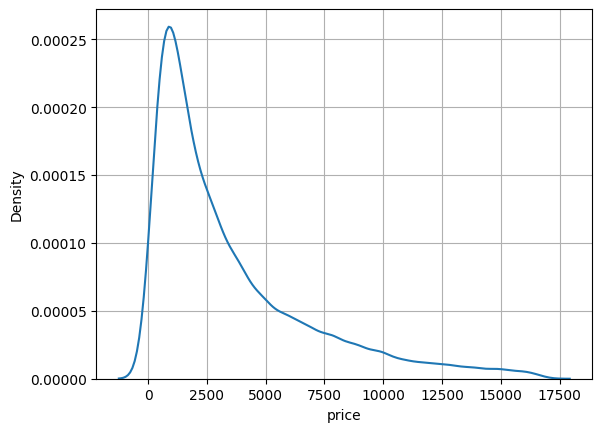

In [66]:
sns.kdeplot(data = df_prepare,
            x = 'price')
plt.grid()

In [67]:
df_prepare['price'].describe().round()

count    36033.0
mean      3485.0
std       3384.0
min          1.0
25%       1000.0
50%       2299.0
75%       4860.0
max      16690.0
Name: price, dtype: float64

# Поменяем немного датасет (ограничим price)

In [68]:
df_prepare_2 = df_prepare[df_prepare['price'] <= 7500]

X_train_2, X_test_2, y_train_2, y_test_2 = split(df_prepare_2)

In [69]:
df_prepare_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31456 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                31456 non-null  int64  
 1   price              31456 non-null  int64  
 2   vehicleType        31456 non-null  object 
 3   gearbox            31456 non-null  object 
 4   model              31456 non-null  object 
 5   odometer           31456 non-null  int64  
 6   fuelType           31456 non-null  object 
 7   notRepairedDamage  31456 non-null  object 
 8   seller             31456 non-null  object 
 9   brand              31456 non-null  object 
 10  powerPS            31456 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 2.9+ MB


In [70]:
'''grid_cat_model = GridSearchCV(estimator = CatBoostRegressor(random_state = RANDOM_STATE,
                                                            loss_function = 'RMSE',
                                                            early_stopping_rounds = 50,
                                                            one_hot_max_size = 20,
                                                            cat_features = cat_features,
                                                            task_type = 'GPU',
                                                            verbose = 0),
                              param_grid = {'iterations': np.arange(1000,2000,200),
                                            'learning_rate': [0.1, 0.05, 0.01]},
                              cv = ShuffleSplit(n_splits = 5,
                                                test_size = 0.2,
                                                random_state = RANDOM_STATE),
                              scoring = RMSE_score)

grid_cat_model.fit(X_train_2, y_train_2)
cat_best = grid_cat_model.best_estimator_
print(grid_cat_model.best_params_)
print(grid_cat_model.best_score_)'''

"grid_cat_model = GridSearchCV(estimator = CatBoostRegressor(random_state = RANDOM_STATE,\n                                                            loss_function = 'RMSE',\n                                                            early_stopping_rounds = 50,\n                                                            one_hot_max_size = 20,\n                                                            cat_features = cat_features,\n                                                            task_type = 'GPU',\n                                                            verbose = 0),\n                              param_grid = {'iterations': np.arange(1000,2000,200),\n                                            'learning_rate': [0.1, 0.05, 0.01]},\n                              cv = ShuffleSplit(n_splits = 5,\n                                                test_size = 0.2,\n                                                random_state = RANDOM_STATE),\n                              s

In [ ]:
y_pred_2 = cat_best.predict(X_test_2)

score2 = RMSE(y_true = y_test_2,
              y_pred = y_pred_2)

score2

915.5540844426017

In [ ]:
df_prepare_2['price'].describe()

count    31456.000000
mean      2435.174784
std       1890.989934
min          1.000000
25%        900.000000
50%       1880.000000
75%       3500.000000
max       7500.000000
Name: price, dtype: float64

# Вывод


### 1-й датасет (не урезанный таргет price)

Длина датасета ---> 36000
На наборе данных с price с базовыми выбросами и без 0
(1 фото - кросс валидация, 2-фото на тесте)

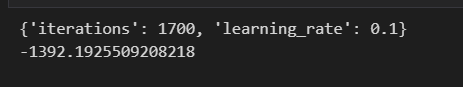


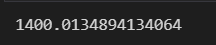

### 2-й датасет (урезанный таргет price)

Длина датасета ---> 31500
(1 фото - кросс валидация, 2-фото на тесте)

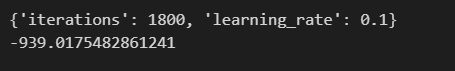


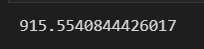


